In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib.scale import LogScale
import json
from utils import dref_dataframe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")

def parse_logs(path: Path, iter: int = 1) -> pd.DataFrame:
    datas = []
    for i in range(iter):
        data = pd.read_csv(path / f"out_{i}.csv")
        meta = json.load((path / f"meta.json").open())
        data["iter"] = i
        data["shrink"] = (data["shrink"] / 1e9) / meta["args"]["mem"]
        data["grow"] = (data["grow"] / 1e9) / meta["args"]["mem"]
        if "touch" in data.columns:
            data["touch"] = (data["touch"] / 1e9) / (meta["args"]["mem"] - 1)
        datas.append(data)
    data = pd.concat(datas)
    match path.stem:
        case n if n.endswith("base-manual"): mode = "virtio-balloon"
        case n if n.endswith("huge-manual"): mode = "virtio-balloon-huge"
        case n if n.endswith("virtio-mem-movable"): mode = "virtio-mem"
        case n if n.endswith("virtio-mem-movable-vfio"): mode = "virtio-mem+VFIO"
        case n if n.endswith("llfree-manual"): mode = "HyperAlloc"
        case n if n.endswith("llfree-manual-vfio"): mode = "HyperAlloc+VFIO"
        case m: mode = m
    data["mode"] = mode
    return pd.DataFrame(data)


     shrink      grow     touch      touch2  iter                 mode  \
0  1.091014  0.433319  0.997458  1379663872     1       virtio-balloon   
0  1.069719  0.434176  0.999031  2206466048     2       virtio-balloon   
0  0.007325  0.003104  0.232260  1110704128     1  virtio-balloon-huge   
0  0.007548  0.003095  0.233308  1125646336     2  virtio-balloon-huge   
0  0.028829  0.009815  0.237765  1130627072     1           virtio-mem   
0  0.028646  0.009731  0.239862  1130627072     2           virtio-mem   
0  0.044588  0.211830  0.073138  1120665600     1      virtio-mem+VFIO   
0  0.044618  0.210503  0.074187  1120665600     2      virtio-mem+VFIO   
0  0.003013  0.000117  0.249037  1275068416     1           HyperAlloc   
0  0.002718  0.000117  0.249561  1280049152     2           HyperAlloc   
0  0.018451  0.000117  0.277348  1280049152     1      HyperAlloc+VFIO   
0  0.017876  0.000117  0.276038  1294991360     2      HyperAlloc+VFIO   

    install  
0  1.430777  
0  1.4332

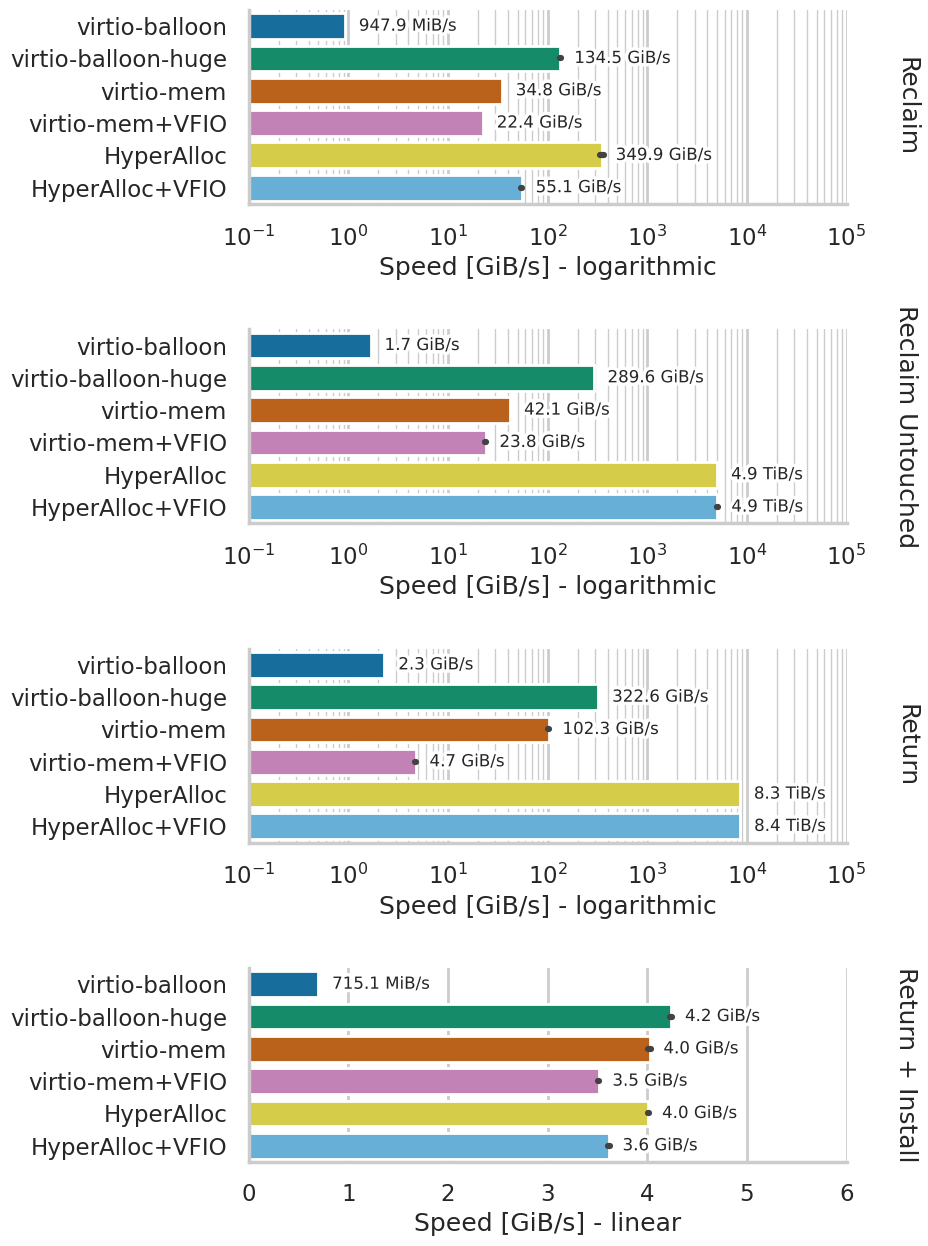

In [2]:
# Touched
paths = [
    Path("inflate/latest-base-manual"),
    Path("inflate/latest-huge-manual"),
    Path("inflate/latest-virtio-mem-movable"),
    Path("inflate/latest-virtio-mem-movable-vfio"),
    Path("inflate/latest-llfree-manual"),
    Path("inflate/latest-llfree-manual-vfio"),
]

data = pd.concat([parse_logs(p, 3) for p in paths])
data = data[data["iter"] > 0]
data["install"] = data["touch"] + data["grow"]
print(data)

pgd = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow", "touch", "install"],
                var_name="op", value_name="time")
pgd["time"] = 1 / pgd["time"]

# Untouched
paths = [
    Path("inflate/latest-nofault-base-manual"),
    Path("inflate/latest-nofault-huge-manual"),
    Path("inflate/latest-nofault-virtio-mem-movable"),
    Path("inflate/latest-nofault-virtio-mem-movable-vfio"),
    Path("inflate/latest-nofault-llfree-manual"),
    Path("inflate/latest-nofault-llfree-manual-vfio"),
]

data = pd.concat([parse_logs(p, 3) for p in paths])
data = data[data["iter"] > 0]
print(data)

pgd1 = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow"],
                var_name="op", value_name="time")
pgd1["time"] = 1 / pgd1["time"]
pgd1 = pgd1[pgd1["op"] == "shrink"]
pgd1["op"] = "Reclaim Untouched"

# Both
pgd = pd.concat([pgd, pgd1])
pgd.loc[pgd["op"] == "shrink", "op"] = "Reclaim"
pgd.loc[pgd["op"] == "grow", "op"] = "Return"
pgd.loc[pgd["op"] == "install", "op"] = "Return + Install"
pgd.loc[pgd["op"] == "touch", "op"] = "Install"
print(pgd["op"].unique())

print(pgd["time"].max())
order = ["virtio-balloon","virtio-balloon-huge","virtio-mem","virtio-mem+VFIO","HyperAlloc","HyperAlloc+VFIO"]
p = sns.FacetGrid(pgd, row="op", margin_titles=True,
                  row_order=["Reclaim", "Reclaim Untouched", "Return", "Return + Install"],
                  aspect=3, height=3.2, sharex=False)

p.map_dataframe(sns.barplot, y="mode", hue="mode", hue_order=order,
                palette="colorblind6", x="time", dodge=False)
p.set(ylabel=None)

# for t in p._margin_titles_texts:
#     # t.xy=(2, 0.5)
#     t.set_x(2)

def mem_fmt(x: float) -> str:
    x *= 1024**3
    sizes = ["TiB", "GiB", "MiB", "KiB"]
    for i, suffix in enumerate(sizes):
        mul = 1024 ** (len(sizes) - i)
        if x > mul: return f"{x/mul:.1f} {suffix}/s"
    return f"{x:.2} B/s"

for key, ax in p.axes_dict.items():
    if key != "Return + Install":
        ax.set(xlim=(1e-1, 1e5))
        ax.set_xscale("log", base=10)
        ax.set(xlabel="Speed [GiB/s] - logarithmic")
    else:
        ax.set(xlim=(0, 6))
        ax.set(xlabel="Speed [GiB/s] - linear")

    ax.grid(True, which="minor", linewidth=1)
    for c in ax.containers:
        ax.bar_label(c, fmt=mem_fmt, fontsize=12, padding=10,
                     path_effects=[patheffects.withStroke(linewidth=5, foreground='white')])
p.set_titles(row_template="{row_name}", xytext=(1.08, 0.5))
p.figure.savefig("inflate/inflate.pdf", bbox_inches="tight")
p.figure.savefig("inflate/inflate.svg", bbox_inches="tight")
dref_dataframe("inflate", Path("inflate"), ["mode", "iter", "op"], pgd)